In [1]:
import os
from ultralytics import NAS
os.chdir("..")
ROOT = os.getcwd()
print(ROOT)


/Users/mautushid/github/Cowsformer


In [2]:
from models.nas import Niche_YOLO_NAS
from super_gradients.training.models import get as get_model
from super_gradients.training import Trainer
from super_gradients.training import models
import torch
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


The console stream is logged into /Users/mautushid/sg_logs/console.log


[2023-08-24 23:19:27] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-08-24 23:19:27] WARNING - redirects.py - NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-08-24 23:19:28] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-08-24 23:19:28] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-08-24 23:19:28] WARNING - export.py - Failed to import pytorch_quantization
[2023-08-24 23:19:28] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-08-24 23:19:28] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [3]:
import yaml


yaml_path = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/data.yaml"

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

CLASSES = data.get('names', [])

print("classes:", CLASSES)


In [4]:
import os

# The path to your data.yaml file
#yaml_path = "data/cow200/yolov5/data.yaml"

# Extract the project name from the path
project = os.path.basename(os.path.dirname(os.path.dirname(yaml_path)))

# Format the project name
EXPERIMENT_NAME = project.lower().replace(" ", "_")

print(EXPERIMENT_NAME)


In [5]:

CHECKPOINT_DIR = '/Users/mautushid/github/Cowsformer/n200_yolo_na_i1_trial100'


In [6]:
from super_gradients.training import Trainer
trainer = Trainer(experiment_name=EXPERIMENT_NAME,
                  ckpt_root_dir=CHECKPOINT_DIR)


In [7]:
MODEL_ARCH = 'yolo_nas_l'
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
best_model = models.get(
    MODEL_ARCH,
    num_classes=80,  # len(dataset_params['classes']),
    checkpoint_path="/Users/mautushid/github/Cowsformer/n200_yolo_na_i1_trial100/ckpt_best.pth"
).to(DEVICE)


classes: ['cow']
cow200


[2023-08-24 23:19:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/n200_yolo_na_i1_trial100/ckpt_best.pth EMA checkpoint.


In [8]:
dataset_params = {
    'data_dir': '/Users/mautushid/github/Cowsformer/data/cow200/yolov5',
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'val/images',
    'val_labels_dir': 'val/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': CLASSES
}
########################################
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)


Caching annotations:  64%|██████▍   | 29/45 [00:00<00:00, 282.88it/s]

In [9]:
##################Define metrics and training parameters###############
train_params = {
    'silent_mode': False,
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [10]:
best_model


YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

In [11]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)


Test:   0%|          | 0/3 [00:00<?, ?it/s][W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Test: 100%|██████████| 3/3 [00:41<00:00, 12.04s/it]

{'Precision@0.50': tensor(0.1339),
 'Recall@0.50': tensor(1.),
 'mAP@0.50': tensor(0.9796),
 'F1@0.50': tensor(0.2362)}

In [12]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path="/Users/mautushid/github/Cowsformer/data/cow200/yolov5/test/images",
    annotations_directory_path="/Users/mautushid/github/Cowsformer/data/cow200/yolov5/test/labels",
    data_yaml_path="/Users/mautushid/github/Cowsformer/data/cow200/yolov5/data.yaml",
    force_masks=False
)


Test: 100%|██████████| 3/3 [00:51<00:00, 17.16s/it]


In [13]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections


In [14]:
import random
random.seed(10)

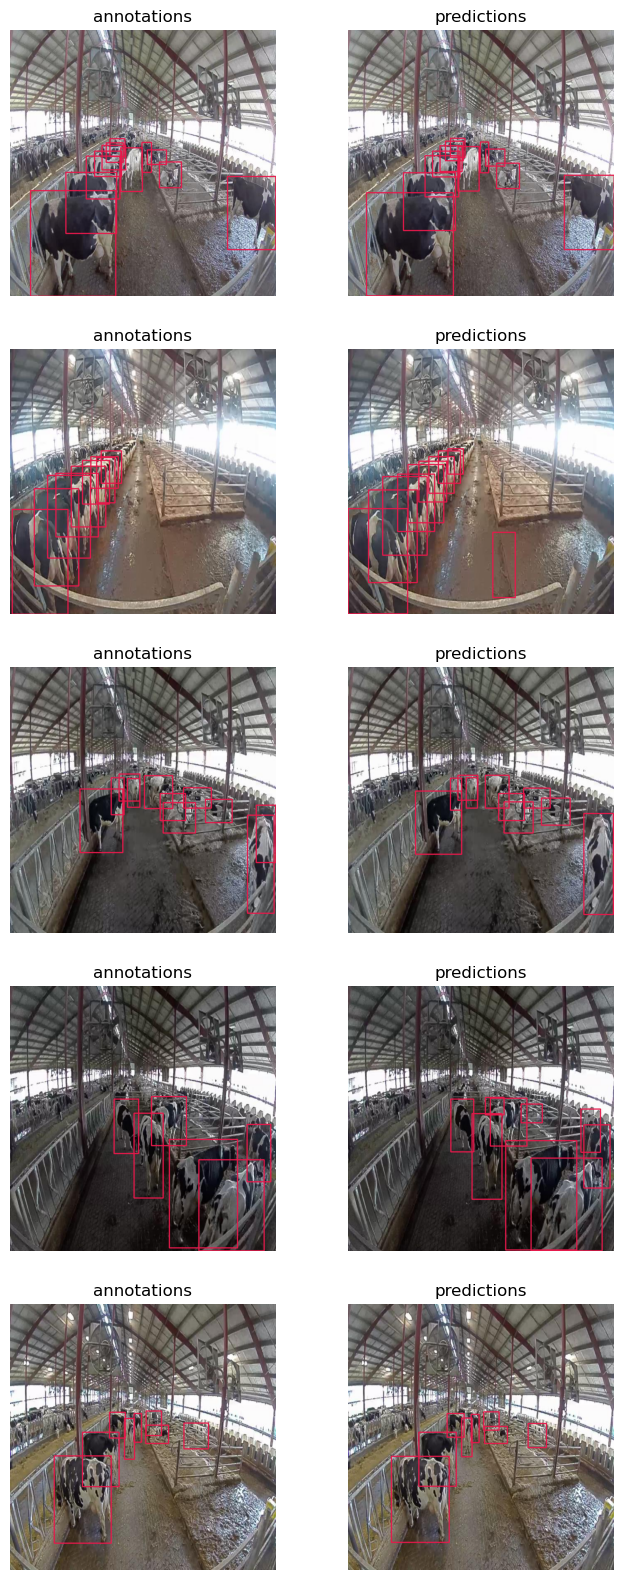

In [15]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles,
                    grid_size=(n, 2), size=(2 * 4, n * 4))


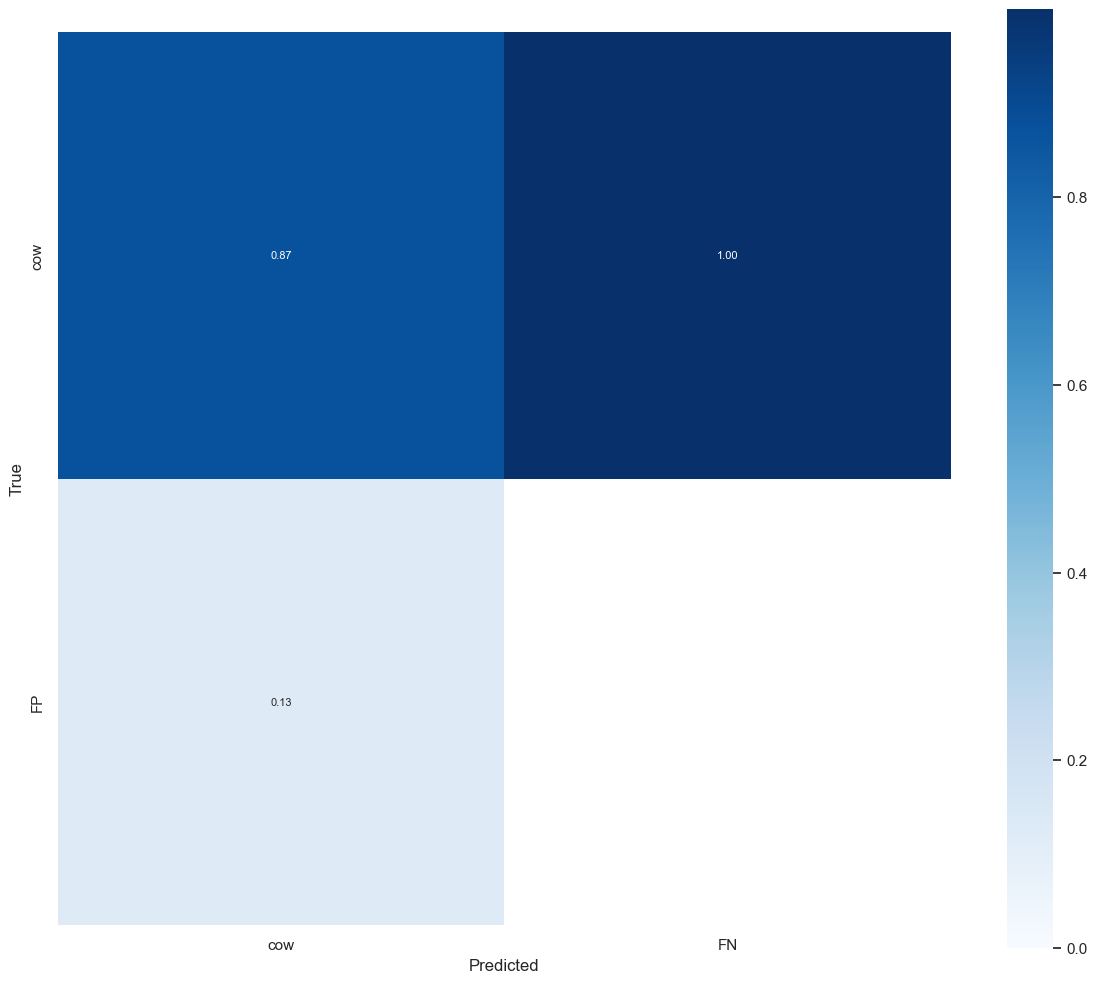

In [16]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation = ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction = predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    #conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(
    ROOT, "confusion_matrix.png"), class_names=ds.classes)


In [21]:
# Assuming confusion_matrix.matrix gives the actual matrix values
cm = confusion_matrix.matrix

# Precision and Recall for each class
precisions = []
recalls = []

num_classes = len(ds.classes)
for i in range(num_classes):
    TP = cm[i, i]
    FP = sum(cm[:, i]) - TP
    FN = sum(cm[i, :]) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0

    precisions.append(precision)
    recalls.append(recall)

# If you want average precision and recall
avg_precision = sum(precisions) / num_classes
avg_recall = sum(recalls) / num_classes

print("Precision per class:", precisions)
print("Recall per class:", recalls)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)


Precision per class: [0.8728606356968215]
Recall per class: [0.9444444444444444]
Average Precision: 0.8728606356968215
Average Recall: 0.9444444444444444


In [18]:
#from onemetric.cv.object_detection import MeanAveragePrecision
import os

import numpy as np

from onemetric.cv.object_detection import MeanAveragePrecision

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation = ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction = predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

mean_average_precision = MeanAveragePrecision.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    
)




In [19]:
mean_average_precision.value


0.8645043191403559